Collaborative Filtering Modelleri
SVD ve Item-Based KNN ile Öneri Sistemi

Proje Açıklaması

Bu projede, Amazon All Beauty ürün veri seti kullanılarak **Collaborative Filtering** (İşbirlikçi Filtreleme) yöntemleriyle bir öneri sistemi geliştirilmiştir.

**Collaborative Filtering Nedir?**
- Kullanıcıların geçmiş davranışlarına (ürün değerlendirmeleri) dayanarak öneriler yapan bir yöntemdir
- Benzer kullanıcılar benzer ürünleri beğenir prensibine dayanır
- Örnek: Kullanıcı A ve B benzer ürünleri beğeniyorsa, A'nın beğendiği bir ürünü B'ye de önerebiliriz

**Bu Projede Yapılanlar:**
1. **SVD (Singular Value Decomposition) Collaborative Filtering**: Matris çarpanlara ayırma yöntemiyle gizli faktörleri bulur
2. **Item-Based KNN Collaborative Filtering**: Benzer ürünleri bulup öneriler yapar
3. **User-Item Matrix Hazırlama**: Verileri model için uygun formata dönüştürme
4. **Hyperparameter Tuning**: En iyi parametreleri bulmak için otomatik arama

**Kullanılan Veri Seti:** All_Beauty.csv (Amazon güzellik ürünleri değerlendirmeleri)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import Dataset, Reader, SVD, KNNBasic, accuracy
from surprise.model_selection import train_test_split, GridSearchCV

%matplotlib inline

print("Kütüphaneler başarıyla yüklendi. ")


Kütüphaneler başarıyla yüklendi. 


 2. Veri Tanımı ve Yüklenmesi

Bu projede kullanılan veri seti, Amazon **All_Beauty** ürünlerine ait kullanıcı
değerlendirmelerini içermektedir.

**Veri Seti Özeti:**
- Kaynak: Amazon Product Review Data (All_Beauty bölümü)
- Ana Değişkenler:
  - `user_id`  → Kullanıcı kimliği
  - `item_id`  → Ürün kimliği
  - `rating`   → Kullanıcının ürüne verdiği puan (1–5 arası)

Bu bölümde veri setini yüklüyor, şemasını (schema) ve temel istatistiklerini inceliyoruz.


In [ ]:
# Sadece gerekli sütunları okuma
#  Not: CSV dosyasında 'asin' sütunu var, ama biz 'item_id' olarak kullanacağız
required_columns = ['user_id', 'asin', 'rating']

df = pd.read_csv(
    "All_Beauty.csv",
    encoding="utf-8",
    usecols=required_columns
)

#  'asin' sütununu 'item_id' olarak yeniden adlandır (daha açıklayıcı)
df = df.rename(columns={'asin': 'item_id'})

# ---- Kontrol: Sütunları göster ----
print("-" * 70)
print(" UYGULANAN SÜTUNLAR (Sadece gerekli olanlar)")
print("-" * 70)

print(f"- DataFrame sütunları  : {list(df.columns)}")
print(f"- Toplam sütun sayısı   : {len(df.columns)}")
print(f"- Beklenen sütunlar     : ['user_id', 'item_id', 'rating']")
print(f"- Tüm sütunlar mevcut   : {all(col in df.columns for col in required_columns)}")
print("-" * 70)

# ---- Veri istatistikleri ----
print("\n Veri İstatistikleri:")
print(f"- Toplam kayıt sayısı           : {len(df):,}")
print(f"- Kullanıcı sayısı (user_id)    : {df['user_id'].nunique():,}")
print(f"- Ürün sayısı (item_id)         : {df['item_id'].nunique():,}")

print("\n Rating dağılımı:")
print(df['rating'].value_counts().sort_index())



----------------------------------------------------------------------
 UYGULANAN SÜTUNLAR (Sadece gerekli olanlar)
----------------------------------------------------------------------
- DataFrame sütunları  : ['user_id', 'item_id', 'rating']
- Toplam sütun sayısı   : 3
- Beklenen sütunlar     : ['user_id', 'item_id', 'rating']
- Tüm sütunlar mevcut   : False
----------------------------------------------------------------------

 Veri İstatistikleri:
- Toplam kayıt sayısı           : 633,693
- Kullanıcı sayısı (user_id)    : 578,813
- Ürün sayısı (item_id)         : 110,941

 Rating dağılımı:
rating
1.0     93762
2.0     39424
3.0     51194
4.0     72378
5.0    376935
Name: count, dtype: int64


## 3. User–Item Matrix Hazırlama ve Sparsity Hesabı

Gerçek hayatta tüm kullanıcı–ürün etkileşimleri büyük bir **User–Item matrisi**
şeklinde temsil edilir.

Bu veri seti çok büyük olduğu için, tüm matrisi belleğe yüklemek
yerine:

- Kullanıcı ve ürün sayısını kullanarak teorik matris boyutunu hesaplıyoruz
- Sparsity (seyreklik) oranını çıkarıyoruz
- Küçük bir örnek alt küme üzerinde User–Item matrisinin şeklini gösteriyoruz.


In [4]:
# Kullanıcı ve ürün sayıları
n_users = df['user_id'].nunique()
n_items = df['item_id'].nunique()
num_ratings = len(df)

print("User–Item teorik matris boyutu:")
print(f"- Kullanıcı sayısı : {n_users:,}")
print(f"- Ürün sayısı      : {n_items:,}")
print(f"- Rating sayısı    : {num_ratings:,}")

total_possible = n_users * n_items
sparsity = 1 - (num_ratings / total_possible)

print(f"\nToplam mümkün hücre sayısı : {total_possible:,}")
print(f"Sparsity (seyreklik) oranı: {sparsity:.6f} (1'e çok yakın → veri çok seyrek)")


User–Item teorik matris boyutu:
- Kullanıcı sayısı : 578,813
- Ürün sayısı      : 110,941
- Rating sayısı    : 633,693

Toplam mümkün hücre sayısı : 64,214,093,033
Sparsity (seyreklik) oranı: 0.999990 (1'e çok yakın → veri çok seyrek)


In [5]:
# Amazon ID problemlerini önlemek için string'e çeviriyoruz
df['user_id'] = df['user_id'].astype(str)
df['item_id'] = df['item_id'].astype(str)

# Küçük bir örnek alt küme: ilk 1000 kullanıcı
sample_users = df['user_id'].unique()[:1000]
df_sample = df[df['user_id'].isin(sample_users)].copy()

print(f"Örnek alt küme oluşturuldu:")
print(f"- Kullanıcı sayısı: {df_sample['user_id'].nunique():,}")
print(f"- Ürün sayısı     : {df_sample['item_id'].nunique():,}")
print(f"- Rating sayısı   : {len(df_sample):,}")

# Sadece bu küçük subset üzerinde pivot table
user_item_sample = df_sample.pivot_table(
    index='user_id',
    columns='item_id',
    values='rating'
)

print("\nÖrnek User–Item matrisi boyutu (subset):")
print(f"- Satır (kullanıcı) : {user_item_sample.shape[0]:,}")
print(f"- Sütun (ürün)      : {user_item_sample.shape[1]:,}")

# İstersen ilk birkaç satırı göster
user_item_sample.iloc[:5, :5]


Örnek alt küme oluşturuldu:
- Kullanıcı sayısı: 1,000
- Ürün sayısı     : 1,831
- Rating sayısı   : 2,160

Örnek User–Item matrisi boyutu (subset):
- Satır (kullanıcı) : 1,000
- Sütun (ürün)      : 1,831


item_id,B000067E30,B000068PBJ,B00011JJNC,B00014DMLO,B00023J4AW
user_id,,,,,
AE2BLXPEH643OUNYUROLEJOHCMWQ,NaN,NaN,NaN,NaN,NaN
AE2HWL6C4SCXHVFJIEEP66DOLSEQ,NaN,NaN,NaN,NaN,NaN
AE2ODKIC3GWQTSYKDMMIYHPJZ7IA,NaN,NaN,NaN,NaN,NaN
AE2ODZ4VYQ5FNNCONSHSNZM7PHSQ,NaN,NaN,NaN,NaN,NaN
AE2SBDV4F2HDUUS4SJKFHSOORBLA,NaN,NaN,NaN,NaN,NaN


## 4. Surprise Dataset ve Train/Test Bölme (SVD için)

Bu bölümde:

1. `df` DataFrame'ini Surprise kütüphanesinin kullanabileceği formata dönüştürüyoruz.
2. Veriyi %80 eğitim ve %20 test olacak şekilde ikiye ayırıyoruz.
3. Bu eğitim ve test setleri SVD modeli için kullanılacaktır.


In [6]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

# Rating ölçeği 1–5 arası
reader = Reader(rating_scale=(1, 5))

# df → Surprise Dataset (sadece user_id, item_id, rating kullanıyoruz)
data = Dataset.load_from_df(df[['user_id', 'item_id', 'rating']], reader)

print("Veri seti Surprise formatına dönüştürüldü.")

# %80 eğitim, %20 test bölmesi
print("\nVeri seti eğitim ve test olarak bölünüyor...")

trainset, testset = train_test_split(
    data,
    test_size=0.2,
    random_state=42
)

train_ratings_count = trainset.n_ratings

print("\n✓ Bölünme tamamlandı!")
print(f"- Eğitim seti boyutu: {train_ratings_count:,} değerlendirme")
print(f"- Test seti boyutu  : {len(testset):,} değerlendirme")

total = train_ratings_count + len(testset)
print(f"\nBölünme oranı: % {train_ratings_count / total * 100:.1f} eğitim, % {len(testset) / total * 100:.1f} test")


Veri seti Surprise formatına dönüştürüldü.

Veri seti eğitim ve test olarak bölünüyor...

✓ Bölünme tamamlandı!
- Eğitim seti boyutu: 506,954 değerlendirme
- Test seti boyutu  : 126,739 değerlendirme

Bölünme oranı: % 80.0 eğitim, % 20.0 test


## 5. SVD (Singular Value Decomposition) Collaborative Filtering

SVD, kullanıcı–ürün matrisini daha küçük matrislere ayırarak **latent faktörleri**
(gizli tercihleri) öğrenen bir öneri yöntemidir.

- Kullanıcılar için latent faktörler → kullanıcı tercihlerini temsil eder  
- Ürünler için latent faktörler    → ürün özelliklerini temsil eder  

Model bu faktörleri kullanarak eksik rating değerlerini tahmin eder.

**Temel Parametreler:**
- `n_factors` → latent faktör sayısı  
- `n_epochs`  → eğitim iterasyon sayısı  
- `lr_all`    → öğrenme hızı  
- `reg_all`   → düzenlileştirme (overfitting'i azaltır)


In [7]:
from surprise import SVD

# SVD modelini başlangıç parametreleriyle oluşturma
svd_model = SVD(
    n_factors=50,
    n_epochs=20,
    lr_all=0.005,
    reg_all=0.02,
    random_state=42
)

print("✓ SVD modeli oluşturuldu.")
print("Parametreler: n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02")

# Modeli eğitme
print("\nSVD modeli eğitiliyor...")
svd_model.fit(trainset)
print("Eğitim tamamlandı!")


✓ SVD modeli oluşturuldu.
Parametreler: n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02

SVD modeli eğitiliyor...
Eğitim tamamlandı!


In [8]:
from surprise import accuracy

print("Test seti üzerinde tahminler yapılıyor...")
svd_predictions = svd_model.test(testset)

print("\nSVD performans metrikleri:")
svd_rmse = accuracy.rmse(svd_predictions)
svd_mae  = accuracy.mae(svd_predictions)

print(f"\nÖzet: SVD RMSE = {svd_rmse:.4f}, MAE = {svd_mae:.4f}")


Test seti üzerinde tahminler yapılıyor...

SVD performans metrikleri:
RMSE: 1.4161
MAE:  1.1617

Özet: SVD RMSE = 1.4161, MAE = 1.1617


## 8. Item-Based KNN Collaborative Filtering

Item-Based KNN, "benzer ürünleri beğenen kullanıcılar, benzer ürünleri beğenir"
prensibine dayanan bir yöntemdir. Bu yöntemde **kullanıcılar arasındaki** benzerlik
yerine, **ürünler arasındaki** benzerlik hesabı yapılır.

**Nasıl çalışır?**
1. Her ürün çifti arasındaki benzerlik hesaplanır (ör. cosine benzerliği).
2. Kullanıcının beğendiği ürünlere en çok benzeyen ürünler bulunur.
3. Bu benzer ürünlerin puanları kullanılarak tahmini rating hesaplanır.

**Temel Parametreler:**
- `k` → Kaç komşu ürün (neighbor) kullanılacak
- `similarity` → Benzerlik ölçüsü (cosine, pearson, msd)
- `user_based=False` → Item-based (ürün bazlı) olduğunu gösterir.


In [9]:
# 1) Amazon ID'leri string'e çevirme (garip index problemlerini önlemek için)
df['user_id'] = df['user_id'].astype(str)
df['item_id'] = df['item_id'].astype(str)

# 2) En çok değerlendirilen ürünleri seçelim
min_ratings_per_item = 5
item_counts = df['item_id'].value_counts()
popular_items = item_counts[item_counts >= min_ratings_per_item].index

# Bellek kısıtına göre maksimum ürün sayısı
max_items = 5000     # RAM azsa 3000'e düşürebilirsin
selected_items = popular_items[:max_items]

# 3) Sadece bu ürünleri içeren alt veri seti
df_knn = df[df['item_id'].isin(selected_items)].copy()

print("KNN için örnek veri seti:")
print(f"- Kayıt sayısı      : {len(df_knn):,}")
print(f"- Kullanıcı sayısı  : {df_knn['user_id'].nunique():,}")
print(f"- Ürün sayısı       : {df_knn['item_id'].nunique():,}")


KNN için örnek veri seti:
- Kayıt sayısı      : 295,793
- Kullanıcı sayısı  : 284,837
- Ürün sayısı       : 5,000


In [10]:
from surprise import Dataset, Reader

# KNN için ayrı Reader (aynı ölçek)
reader_knn = Reader(rating_scale=(1, 5))

# DataFrame → Surprise Dataset
data_knn = Dataset.load_from_df(
    df_knn[['user_id', 'item_id', 'rating']],
    reader_knn
)

print("KNN için Surprise dataset oluşturuldu.")

# Eğitim / test bölmesi (%80 / %20)
from surprise.model_selection import train_test_split

print("\nKNN için eğitim ve test seti oluşturuluyor...")
trainset_knn, testset_knn = train_test_split(
    data_knn,
    test_size=0.2,
    random_state=42
)

print(f"\n✓ KNN eğitim seti: {trainset_knn.n_users} kullanıcı, "
      f"{trainset_knn.n_items} ürün, {trainset_knn.n_ratings} değerlendirme")
print(f"✓ KNN test seti  : {len(testset_knn):,} değerlendirme")


KNN için Surprise dataset oluşturuldu.

KNN için eğitim ve test seti oluşturuluyor...

✓ KNN eğitim seti: 229343 kullanıcı, 5000 ürün, 236634 değerlendirme
✓ KNN test seti  : 59,159 değerlendirme


In [11]:
from surprise import KNNBasic, accuracy

# Item-Based KNN ayarları
sim_options = {
    'name': 'cosine',   # benzerlik ölçüsü
    'user_based': False # Item-Based (ürün bazlı)
}

knn_model = KNNBasic(
    k=40,               # kaç benzer ürün kullanılacak
    sim_options=sim_options,
    verbose=False
)

print("Item-Based KNN modeli oluşturuldu. Eğitim başlıyor...")
knn_model.fit(trainset_knn)
print("KNN eğitimi tamamlandı.")

# Test setinde değerlendirme
print("\nKNN performans metrikleri:")
knn_predictions = knn_model.test(testset_knn)
knn_rmse = accuracy.rmse(knn_predictions)
knn_mae  = accuracy.mae(knn_predictions)

print(f"\nÖzet: KNN RMSE = {knn_rmse:.4f}, MAE = {knn_mae:.4f}")


Item-Based KNN modeli oluşturuldu. Eğitim başlıyor...
KNN eğitimi tamamlandı.

KNN performans metrikleri:
RMSE: 1.4595
MAE:  1.2061

Özet: KNN RMSE = 1.4595, MAE = 1.2061


## 12. Hyperparameter Tuning – SVD

Bu bölümde SVD modelinin hiper-parametreleri `GridSearchCV` ile
optimize edilmiştir. Amaç, RMSE değerini düşüren parametre kombinasyonunu bulmaktır.


In [12]:
from surprise.model_selection import GridSearchCV

print("=" * 70)
print(" SVD HYPERPARAMETER TUNING")
print("=" * 70)

# Parametre ızgarası (küçük tuttuk ki eğitim süresi makul olsun)
param_grid_svd = {
    'n_factors': [50, 100],
    'n_epochs' : [15, 25],
    'lr_all'   : [0.002, 0.005],
    'reg_all'  : [0.02, 0.1]
}

print("   Parametre ızgarası:")
print(f"     • n_factors: {param_grid_svd['n_factors']}")
print(f"     • n_epochs : {param_grid_svd['n_epochs']}")
print(f"     • lr_all   : {param_grid_svd['lr_all']}")
print(f"     • reg_all  : {param_grid_svd['reg_all']}")
print(f"   Cross-Validation: 3-fold")
print("=" * 70)

gs_svd = GridSearchCV(
    SVD,
    param_grid_svd,
    measures=['rmse'],
    cv=3,
    n_jobs=-1  # uygun çekirdek sayısını kullan
)

print("\n" + "=" * 70)
print(" SVD İÇİN GRIDSEARCH ÇALIŞIYOR...")
print("=" * 70)
print("    Bu işlem biraz zaman alabilir...")

gs_svd.fit(data)

print("\n" + "=" * 70)
print(" SVD İÇİN EN İYİ SONUÇLAR")
print("=" * 70)
print(f"   En iyi RMSE skoru     : {gs_svd.best_score['rmse']:.6f}")
print("\n" + "-" * 70)
print("  EN İYİ PARAMETRE SETİ")
print("-" * 70)

best_svd_params = gs_svd.best_params['rmse']
for key, value in best_svd_params.items():
    print(f"  • {key:12s} : {value}")

print("=" * 70)


 SVD HYPERPARAMETER TUNING
   Parametre ızgarası:
     • n_factors: [50, 100]
     • n_epochs : [15, 25]
     • lr_all   : [0.002, 0.005]
     • reg_all  : [0.02, 0.1]
   Cross-Validation: 3-fold

 SVD İÇİN GRIDSEARCH ÇALIŞIYOR...
    Bu işlem biraz zaman alabilir...

 SVD İÇİN EN İYİ SONUÇLAR
   En iyi RMSE skoru     : 1.422192

----------------------------------------------------------------------
  EN İYİ PARAMETRE SETİ
----------------------------------------------------------------------
  • n_factors    : 50
  • n_epochs     : 25
  • lr_all       : 0.005
  • reg_all      : 0.02


In [13]:
# En iyi parametrelerle yeni SVD modeli
svd_best = SVD(
    n_factors=best_svd_params['n_factors'],
    n_epochs=best_svd_params['n_epochs'],
    lr_all=best_svd_params['lr_all'],
    reg_all=best_svd_params['reg_all'],
    random_state=42
)

print("En iyi parametrelerle SVD modeli yeniden eğitiliyor...")
svd_best.fit(trainset)
print("Eğitim tamamlandı.")

# Test setinde değerlendirme
print("\nTuned SVD performans metrikleri:")
svd_best_predictions = svd_best.test(testset)
svd_best_rmse = accuracy.rmse(svd_best_predictions)
svd_best_mae  = accuracy.mae(svd_best_predictions)

print(f"\nÖzet: Tuned SVD RMSE = {svd_best_rmse:.4f}, MAE = {svd_best_mae:.4f}")


En iyi parametrelerle SVD modeli yeniden eğitiliyor...
Eğitim tamamlandı.

Tuned SVD performans metrikleri:
RMSE: 1.4143
MAE:  1.1575

Özet: Tuned SVD RMSE = 1.4143, MAE = 1.1575


## 13. Hyperparameter Tuning – Item-Based KNN

KNN modeli için farklı `k` değerleri ve benzerlik fonksiyonları denenmiş,
RMSE'yi minimize eden kombinasyon seçilmiştir.


In [14]:
# KNN için parametre ızgarası
param_grid_knn = {
    'k': [20, 40],
    'sim_options': {
        'name': ['cosine', 'pearson'],
        'user_based': [False]  # sadece item-based
    }
}

gs_knn = GridSearchCV(
    KNNBasic,
    param_grid_knn,
    measures=['rmse'],
    cv=2,
    n_jobs=-1
)

print("KNN için GridSearch başlıyor...")
gs_knn.fit(data_knn)

print("\nKNN için en iyi sonuçlar:")
print("En iyi RMSE skoru     :", gs_knn.best_score['rmse'])
print("En iyi parametre seti :", gs_knn.best_params['rmse'])
best_knn_params = gs_knn.best_params['rmse']


KNN için GridSearch başlıyor...

KNN için en iyi sonuçlar:
En iyi RMSE skoru     : 1.4628066207966182
En iyi parametre seti : {'k': 20, 'sim_options': {'name': 'cosine', 'user_based': False}}


In [15]:
# En iyi parametrelerle KNN modeli
best_sim_options = best_knn_params['sim_options']

knn_best = KNNBasic(
    k=best_knn_params['k'],
    sim_options=best_sim_options,
    verbose=False
)

print("En iyi parametrelerle KNN modeli yeniden eğitiliyor...")
knn_best.fit(trainset_knn)
print("KNN eğitimi tamamlandı.")

print("\nTuned KNN performans metrikleri:")
knn_best_predictions = knn_best.test(testset_knn)
knn_best_rmse = accuracy.rmse(knn_best_predictions)
knn_best_mae  = accuracy.mae(knn_best_predictions)

print(f"\nÖzet: Tuned KNN RMSE = {knn_best_rmse:.4f}, MAE = {knn_best_mae:.4f}")


En iyi parametrelerle KNN modeli yeniden eğitiliyor...
KNN eğitimi tamamlandı.

Tuned KNN performans metrikleri:
RMSE: 1.4595
MAE:  1.2061

Özet: Tuned KNN RMSE = 1.4595, MAE = 1.2061


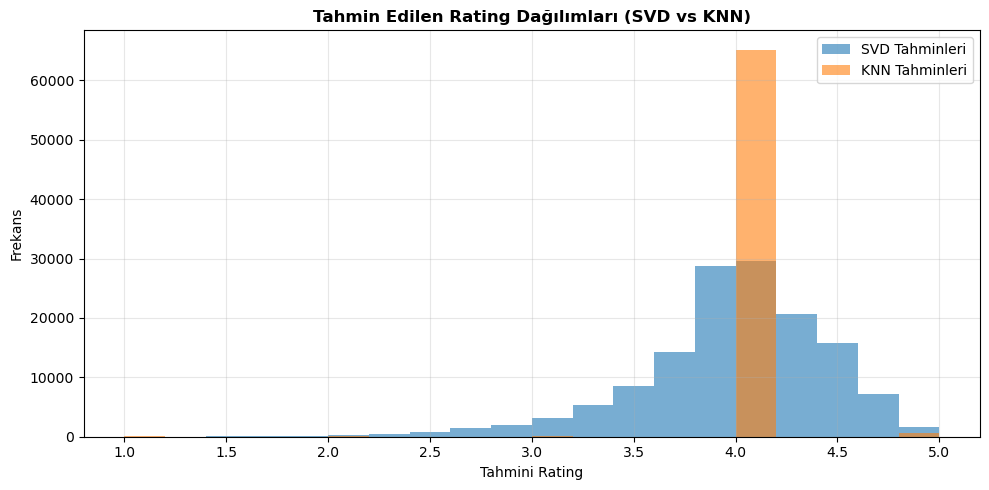

In [ ]:
# 5. Predictions Dağılımı (SVD & KNN) 

# Eğer tuned SVD tahminleri svd_best_predictions ise:
svd_est_values = [p.est for p in svd_best_predictions]   # veya svd_predictions
knn_est_values = [p.est for p in knn_best_predictions]   # veya knn_predictions

plt.figure(figsize=(10,5))
plt.hist(svd_est_values, bins=20, alpha=0.6, label='SVD Tahminleri')
plt.hist(knn_est_values, bins=20, alpha=0.6, label='KNN Tahminleri')
plt.title('Tahmin Edilen Rating Dağılımları (SVD vs KNN)', fontsize=12, fontweight='bold')
plt.xlabel('Tahmini Rating', fontsize=10)
plt.ylabel('Frekans', fontsize=10)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [16]:
# ===================== 6. Top-K Recommendation Fonksiyonları ==================

def get_top_k_recommendations(model, df_source, user_id, all_items, k=10):
    """
    model      : Surprise modeli (SVD veya KNN)
    df_source  : rating'lerin alındığı DataFrame (SVD için df, KNN için df_knn)
    user_id    : öneri yapılacak kullanıcı
    all_items  : modelin bildiği tüm item_id listesi
    k          : öneri sayısı
    """
    # Kullanıcının zaten değerlendirdiği ürünler
    rated_items = set(df_source[df_source['user_id'] == user_id]['item_id'].unique())
    
    # Henüz puan vermediği ürünler
    items_to_score = [iid for iid in all_items if iid not in rated_items]
    
    # Tahmin yap
    preds = [model.predict(str(user_id), str(iid)) for iid in items_to_score]
    
    # Tahmini rating'e göre sırala (yüksekten düşüğe)
    preds_sorted = sorted(preds, key=lambda x: x.est, reverse=True)
    
    return preds_sorted[:k]

# -------------------- Örnek Kullanım: SVD (Tuned) -----------------------------

example_user = df['user_id'].iloc[0]      # istersen başka bir user_id seç
all_items_svd = df['item_id'].unique()

top_k_svd = get_top_k_recommendations(
    model=svd_best,           # tuned SVD model
    df_source=df,
    user_id=example_user,
    all_items=all_items_svd,
    k=10
)

print(f"\nSVD ile Kullanıcı {example_user} için Top-10 öneri:")
for p in top_k_svd:
    print(f"  item_id={p.iid}, tahmini rating={p.est:.3f}")

# -------------------- Örnek Kullanım: KNN (Tuned) -----------------------------

# KNN sadece df_knn (popüler item'lar) üzerinde eğitildi, onu kullanıyoruz
all_items_knn = df_knn['item_id'].unique()

top_k_knn = get_top_k_recommendations(
    model=knn_best,           # tuned KNN model
    df_source=df_knn,
    user_id=example_user,
    all_items=all_items_knn,
    k=10
)

print(f"\nItem-Based KNN ile Kullanıcı {example_user} için Top-10 öneri:")
for p in top_k_knn:
    print(f"  item_id={p.iid}, tahmini rating={p.est:.3f}")



SVD ile Kullanıcı AGKHLEW2SOWHNMFQIJGBECAF7INQ için Top-10 öneri:
  item_id=B00XQOR3JS, tahmini rating=5.000
  item_id=B08L5KN7X4, tahmini rating=5.000
  item_id=B01850QOWE, tahmini rating=5.000
  item_id=B078W2K47L, tahmini rating=5.000
  item_id=B01BRVADG6, tahmini rating=5.000
  item_id=B006WZD7FW, tahmini rating=5.000
  item_id=B00FGA6NC8, tahmini rating=5.000
  item_id=B00U6CGVDM, tahmini rating=5.000
  item_id=B07D231R46, tahmini rating=5.000
  item_id=B01I24RSH8, tahmini rating=5.000

Item-Based KNN ile Kullanıcı AGKHLEW2SOWHNMFQIJGBECAF7INQ için Top-10 öneri:
  item_id=B07TLMZL3T, tahmini rating=5.000
  item_id=B01N47XMWS, tahmini rating=5.000
  item_id=B06XSN9J9L, tahmini rating=5.000
  item_id=B08P2DZB4X, tahmini rating=4.008
  item_id=B07GDQPG12, tahmini rating=4.008
  item_id=B01M7UMAUG, tahmini rating=4.008
  item_id=B07ZJKVVLW, tahmini rating=4.008
  item_id=B082QX2HP6, tahmini rating=4.008
  item_id=B01AKTGHFW, tahmini rating=4.008
  item_id=B083BDVS36, tahmini rating=4

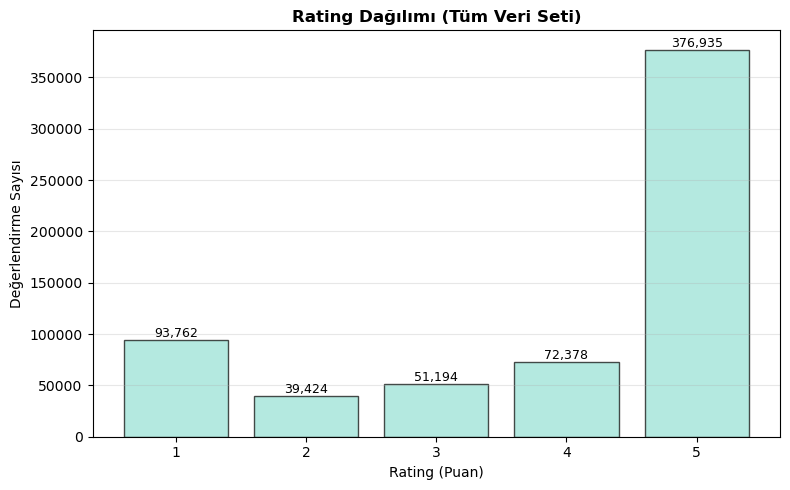

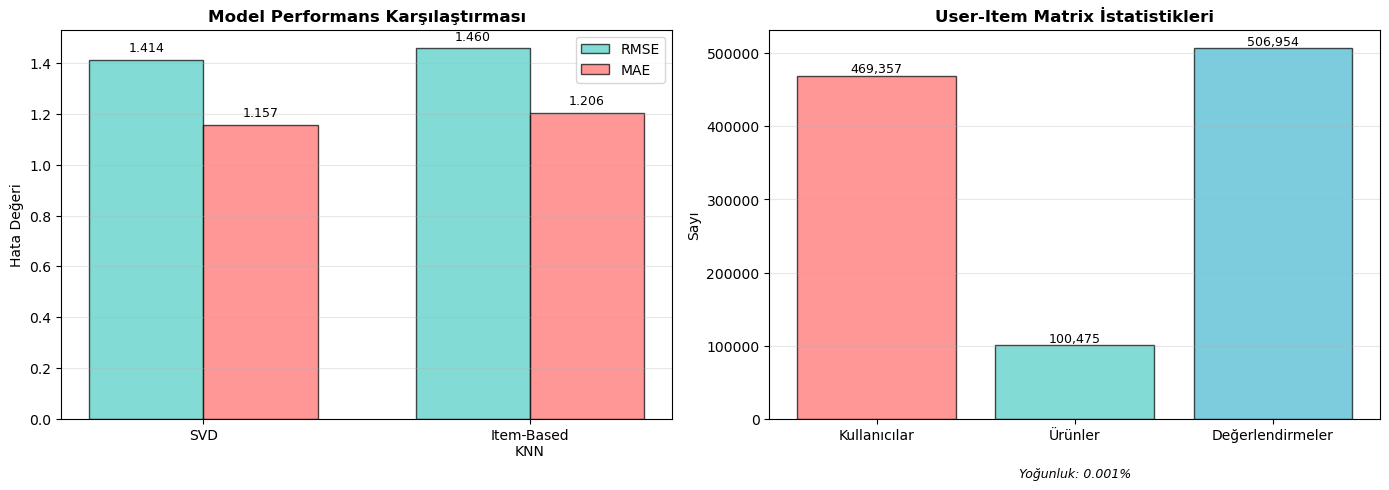


MODEL KARŞILAŞTIRMA TABLOSU

                     Model     RMSE      MAE
           SVD (Optimized) 1.414278 1.157474
Item-Based KNN (Optimized) 1.459509 1.206119


✓ En İyi Model: SVD (Optimized)
  RMSE: 1.4143
  MAE: 1.1575

HYPERPARAMETER TUNING SONUÇLARI

SVD En İyi Parametreler:
  n_factors: 50
  n_epochs: 25
  lr_all: 0.005
  reg_all: 0.02
  Cross-Validation RMSE: 1.4222

Item-Based KNN En İyi Parametreler:
  k (komşu sayısı): 20
  similarity: cosine
  user_based: False
  Cross-Validation RMSE: 1.4628



In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ========== 0. Rating Dağılımı (Tüm Veri Seti) ==========
plt.figure(figsize=(8, 5))
rating_counts = df['rating'].value_counts().sort_index()
bars = plt.bar(rating_counts.index, rating_counts.values, color='#95E1D3', alpha=0.7, edgecolor='black')
plt.title('Rating Dağılımı (Tüm Veri Seti)', fontsize=12, fontweight='bold')
plt.xlabel('Rating (Puan)', fontsize=10)
plt.ylabel('Değerlendirme Sayısı', fontsize=10)
plt.xticks(rating_counts.index)
plt.grid(axis='y', alpha=0.3)

# Değerleri çubukların üzerine yazdır
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# ========== 1. Model Performans Karşılaştırması ==========
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# RMSE ve MAE karşılaştırması (tuned modellerden)
models = ['SVD', 'Item-Based\nKNN']
rmse_values = [svd_best_rmse, knn_best_rmse]
mae_values = [svd_best_mae, knn_best_mae]
x = np.arange(len(models))
width = 0.35

bars1 = ax1.bar(x - width/2, rmse_values, width, label='RMSE', color='#4ECDC4', alpha=0.7, edgecolor='black')
bars2 = ax1.bar(x + width/2, mae_values, width, label='MAE', color='#FF6B6B', alpha=0.7, edgecolor='black')

ax1.set_title('Model Performans Karşılaştırması', fontsize=12, fontweight='bold')
ax1.set_ylabel('Hata Değeri', fontsize=10)
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

for i, (rmse, mae) in enumerate(zip(rmse_values, mae_values)):
    ax1.text(i - width/2, rmse + 0.02, f'{rmse:.3f}', ha='center', va='bottom', fontsize=9)
    ax1.text(i + width/2, mae + 0.02, f'{mae:.3f}', ha='center', va='bottom', fontsize=9)

# User-Item Matrix İstatistikleri
matrix_stats = {
    'Kullanıcılar': trainset.n_users,
    'Ürünler': trainset.n_items,
    'Değerlendirmeler': trainset.n_ratings
}
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
bars = ax2.bar(matrix_stats.keys(), matrix_stats.values(), color=colors, alpha=0.7, edgecolor='black')
ax2.set_title('User-Item Matrix İstatistikleri', fontsize=12, fontweight='bold')
ax2.set_ylabel('Sayı', fontsize=10)
ax2.grid(axis='y', alpha=0.3)

for i, (key, val) in enumerate(matrix_stats.items()):
    ax2.text(i, val + 50, f'{val:,}', ha='center', va='bottom', fontsize=9)

# Matrix yoğunluğu
matrix_density = (trainset.n_ratings / (trainset.n_users * trainset.n_items)) * 100
ax2.text(0.5, -0.15, f'Yoğunluk: {matrix_density:.3f}%', 
         transform=ax2.transAxes, ha='center', fontsize=9, style='italic')

plt.tight_layout()
plt.show()

# ========== 2. Karşılaştırma Tablosu ==========
print("\n" + "=" * 70)
print("MODEL KARŞILAŞTIRMA TABLOSU")
print("=" * 70)

comparison_df = pd.DataFrame({
    'Model': ['SVD (Optimized)', 'Item-Based KNN (Optimized)'],
    'RMSE': [svd_best_rmse, knn_best_rmse],
    'MAE': [svd_best_mae, knn_best_mae]
})

print("\n" + comparison_df.to_string(index=False))
print("\n" + "=" * 70)

# En iyi modeli belirle
best_model_idx = comparison_df['RMSE'].idxmin()
best_model = comparison_df.loc[best_model_idx, 'Model']
print(f"\n✓ En İyi Model: {best_model}")
print(f"  RMSE: {comparison_df.loc[best_model_idx, 'RMSE']:.4f}")
print(f"  MAE: {comparison_df.loc[best_model_idx, 'MAE']:.4f}")

# Hyperparameter tuning sonuçları
print("\n" + "=" * 70)
print("HYPERPARAMETER TUNING SONUÇLARI")
print("=" * 70)

svd_params = gs_svd.best_params['rmse']
knn_params = gs_knn.best_params['rmse']

print("\nSVD En İyi Parametreler:")
print(f"  n_factors: {svd_params['n_factors']}")
print(f"  n_epochs: {svd_params['n_epochs']}")
print(f"  lr_all: {svd_params['lr_all']}")
print(f"  reg_all: {svd_params['reg_all']}")
print(f"  Cross-Validation RMSE: {gs_svd.best_score['rmse']:.4f}")

print("\nItem-Based KNN En İyi Parametreler:")
print(f"  k (komşu sayısı): {knn_params['k']}")
print(f"  similarity: {knn_params['sim_options']['name']}")
print(f"  user_based: {knn_params['sim_options']['user_based']}")
print(f"  Cross-Validation RMSE: {gs_knn.best_score['rmse']:.4f}")

print("\n" + "=" * 70)
